# Web Intelligence - Deduplication Challenge

This jupyter notebook contains brief documentation and all function calls which are used to reproduce our results.

<b>Table of contents:</b><br>
I. TheDeDuplicators: Team composition<br>
II. Brief description of the approach and all steps<br>
III. Reproducibility<br>
IV. Final output and summary

## I. TheDeDuplicators: Team composition

<img src="images/logo.PNG"  width="200px"/>
<p style="font-size: 14px">
Dimitrios Petridis, MSc Economics, Data Analyst<br><br>
Stefan Pasch, PhD Economics, Data Scientist<br><br>
Jannic Cutura, PhD Economics, Data & Software Engineer<br><br>
Charalampos Lagonidis, MSc student (AI and Data Analytics), Research Assistant (NLP)
<br clear="left"/>

## II. Brief description of the approach and all steps
1) [**`find_perfect_matches.py`**](src/find_perfect_matches.py): Finds all <b>FULL</b> and all (full) <b>TEMPORAL</b> duplicates. Full duplicates are exactly identical in terms of title, description and retrieval date. In this step, we also identify a large group of temporal duplicates, where description and title perfectly align, but the retrievel dates differ. This process is applied on the raw data before the text preprocessing takes place.
 
2) [**`clean_input_dataset.py`**](src/clean_input_data_set.py): An initial cleaning step (text preprocessing) which peforms multiple operations on the raw data (e.g, removes spurious information like HTML tags etc.) and yields an intermediate dataset.
 
3) [**`prepare_input_for_embedding.py`**](src/prepare_input_for_embedding.py): Translates the non-English descriptions of the cleaned dataset into English using the GoogleTrans API. The translation is optional, but highly recommended in order to improve the accuracy later. Finally, it merges title and description applying a weight on the title.
 
4) [**`pre_filtering_for_plausible_matches.py`**](src/pre_filtering_for_plausible_matches.py): Given the vast number of job postings, which is around 120,000, comparing each one against every other one would result in an impractical 6.27 billion combinations. This is because individual comparisons may not be simple. Therefore, before applying more expert rule selection criteria, we must reduce the complexity. To accomplish this, we utilize a combination of embedding models and FAISS index search:
   
    a) We utilize a language embedding model on all distinct values of the job title and job description from the previous step (translated or original job postings). The MPNET model is one of the latest embedding models that can project text information into a vector space. If two pieces of text convey the same message but are worded differently, they will point to a comparable vector of 384 floating point numbers. In case the dataset is not translated, MINILM or DISTILUSE multilingual models can be used, instead.
   
    b) To identify partial, temporal and semantic duplicates, we compare these vectors with one another by calculating the L2 distance between each pair. We have created the most effective implementation of this comparison by using a FAISS index search, which is similar in essence to Lucene's elastic search. We store the 100 nearest matches for each ID.
    
    c) Lastly, we reassemble the pre-filtered dataset, excluding the duplicates found in step 1.

5) [**`apply_expert_rules.py`**](src/embedding_process/apply_expert_rules.py): After acquiring the 100 nearest matches for each job ID, we have reduced the complexity of the issue by 99.9%, which is roughly ((112000-100)/112000)! With this subset of matched tuples, we apply some more computationally intensive expert rules based on string similarity and overlaps. These expert rules enable us to distinguish between <b>SEMANTIC</b>, <b>TEMPORAL</b> and <b>PARTIAL</b> duplicates.

## III. Reproducibility
In order to reproduce our results, execute the code below, by following the instructions/steps.

### Preliminary steps

Before starting, make sure to create a new folder in the root directory named `data`. Inside that directory, create a subdirectory named `input_data`, and place the input data set here: [`data/input_data/wi_dataset.csv`](data/input_data/wi_dataset.csv). Everything else should work as describe below. 

Next, you need to install all the dependencies, which are tracked in [**`requirements.txt`**](requirements.txt) (as this is typical for a python project):

In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 72.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 74.4 MB/s eta 0:00:0000:0100:01
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached sentence-transformers-2.2.2.tar.gz (85 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.3 MB/s eta 0:00:0000:01:00:01
  Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 46.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.1/781.1 kB 85.4 MB/s eta 0:00:00
  Using 

Great, now all dependencies are installed.

Next, we need to create some folders to store all intermediate and output data:

In [4]:
from src.utilities.utility_functions_helpers import create_required_folders
create_required_folders()

The directory for the input data already exists at data/input_data.
The directory for the intermediate data already exists at data/intermediate_data.
The directory for the output data has been created successfully at data/output_data.


Great, all necessary folders have been created!

Execution time: <b>Less than 1 minute</b>

### 1. Find perfect matches

In this first step, we are looking for all perfect duplicates in the dataset.<br>
First, let's load the function to identify all <b>FULL</b> and (full) <b>TEMPORAL</b> duplicates:

In [5]:
from src.find_perfect_matches import find_perfect_duplicates

In [6]:
find_perfect_duplicates()

Input data path: data/input_data/wi_dataset.csv
Reading in the input data...
The file was read successfully!
The raw data contain 112064 job advertisements in total.

Performing operations...

8 sketchy IDs were found.
Dropping completely the rows with sketchy IDs (if any)...
The data now contain 112056 job advertisements in total.
0 missing values were found in the titles.
30364 missing values were found in the company names.
29 missing values were found in the descriptions.
8 missing values were found in the retrieval dates.
61471 missing values were found in the locations.
8 missing values were found in the country ids.

Turning the retrieval dates to integers...

Replacing missing values (if any) with ''...

Detecting FULL and (full) TEMPORAL duplicates in terms of retrieval date, title, and description...
The following number of duplicate combinations were found:
     type
FULL         63371
TEMPORAL    294106
Name: id1, dtype: int64

Saved at data/intermediate_data/full_duplicate

Execution time: <b>Less than 1 minute</b>

### 2. Clean raw data

In this step, the text pre-processing takes place. We basically drop or modify non ASCII weird characters and punctuations, remove HTML tags etc. We also create some helper columns that will be used later.<br>
Let's load the cleaning function:

In [10]:
from src.clean_input_data_set import clean_input_dataset

In [11]:
clean_input_dataset()

Input data path: data/input_data/wi_dataset.csv
Reading in the input data...
The file was read successfully!
The raw data contain 112064 job advertisements in total.
After importing the raw data, the following columns were discovered:
id                string
title             string
description       string
location          string
country_id        string
company_name      string
retrieval_date    string
dtype: object

Performing operations...

8 sketchy IDs were found.
Dropping completely the rows with sketchy IDs (if any)...
The data now contain 112056 job advertisements in total.
0 missing values were found in the titles.
30364 missing values were found in the company names.
29 missing values were found in the descriptions.
8 missing values were found in the retrieval dates.
61471 missing values were found in the locations.
8 missing values were found in the country ids.

Turning the retrieval dates to integers...

Replacing missing values (if any) with ''...

Starting cleaning fo

Cleaning descriptions: 100%|██████████| 112056/112056 [01:11<00:00, 1559.95it/s]



There are 15899 unique company names.
There are 15883 unique company names after cleaning them.
There are 53192 unique titles.
There are 53167 unique titles after cleaning them.
There are 59022 unique descriptions.
There are 58991 unique descriptions after cleaning them.
Creating additional helper columns...

Before saving intermediate result the following columns and data types are available:
id                     Int64
title                 string
description           string
location              string
country_id            string
company_name          string
retrieval_date         Int64
company_name_clean    string
title_clean           string
description_clean     string
description_hash       Int64
title_hash             Int64
dtype: object

Saved to data/intermediate_data/formatted_data.parquet.


Execution time: <b>Less than 2 minutes</b>

### 3. Prepare input for embedding (with optional translations)

In the next step, transations take place. Translating the dataset is an optional step but highly recommended. We also create a merged column of title and description that will be used later in the embedding process.<br>
Let's load the function:

In [12]:
from src.prepare_input_for_embedding import prepare_input_data_for_embedding

Now, we need to decide whether we want to proceed with translating the job advertisments and using an english model (<b>mpnet</b>) or not translating the job advertisments and using a multilingual model (<b>distiluse</b> or <b>minilm</b>).

Method 1.<br>
In case we decide to translate the text, the process will take ~8 additional hours. For that, the Google API translation is used.
Moreover, the embedding model described above is applied on the combined translated title and description where we concatenate both columns but supply a weight to the title (since job titles are on average much shorter than job descriptions but relatively more important).

<br>Method 2.<br>In case we decide to not translate the text, one of the two multilingual models has to be selected. Again, the embedding model is applied on the combined cleaned, original title and description.

#### Translations
If you would like to translate the dataset and continue with Method 1, set the parameter <i>TRANSLATION</i> below to <i>True</i>.<br>
If instead, you would like to not translate the dataset and continue with Method 2, set the parameter <i>TRANSLATION</i> below to <i>False</i>:

In [13]:
TRANSLATION = True

In [14]:
prepare_input_data_for_embedding(title_weight=0.3,
                                 translation=TRANSLATION)

Formatted data path: data/intermediate_data/formatted_data.parquet
Reading in the formatted data...
The file was read successfully!

Starting translations...



Translating descriptions: 100%|██████████| 58991/58991 [4:41:06<00:00,  3.50it/s]   
/home/studio-lab-user/DeduplicationChallenge/src/prepare_input_for_embedding.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_desc[DataDimensions.DESCRIPTION_TRANSLATED] = df_desc[DataDimensions.DESCRIPTION_CLEAN].progress_apply(
Translating titles: 100%|██████████| 53167/53167 [3:16:43<00:00,  4.50it/s]   
/home/studio-lab-user/DeduplicationChallenge/src/prepare_input_for_embedding.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi


Before saving translated result the following columns and data types are available:
id                             Int64
title                         string
description                   string
location                      string
country_id                    string
company_name                  string
retrieval_date                 Int64
company_name_clean            string
title_clean                   string
description_clean             string
description_hash               Int64
title_hash                     Int64
description_translated        string
title_translated              string
title_and_description         string
title_and_description_hash     Int64
dtype: object

Saved to data/intermediate_data/intermediate_data.parquet.


Execution time with Method 1 (Translating): <b>Approximately 8 hours</b><br>
Execution time with Method 2 (Not translating): <b>Less than 1 minute</b>

### 4. Use Transformer models to create overall embeddings

Frist, we have to load the embedding model class:

In [1]:
from src.embedding_models import EmbeddingModel

#### Language models
While we have them installed already, we need to download the data for the language model. For convenience it is stored in a class; upon initializing a model for the first time it will automatically be downlaoded to `data/models/`. Subsequent runs will simply load it from there (so it will not have to be downloaded again). We tested a range of different embedding models and finally settled on `mpnet` for the translated data, and `distiluse` or `minilm` for the non-translated data (multilingual models). A comprehensive review can be found [here](https://www.sbert.net/docs/pretrained_models.html). 

Now, we need to select the desired model, based on method we followed above:

In [3]:
# In case we translated the dataset (Method 1), initialize/download english model:
model = EmbeddingModel(model='mpnet', max_seq_length=384)

# In case we did not translate the dataset (Method 2), initialize/download one of the two mutilingual models:
# model = EmbeddingModel(model='distiluse', max_seq_length=512)
# or
# model = EmbeddingModel(model='minilm', max_seq_length=512)

Great! Now, we need to import the functions for the prefiltering:

In [4]:
from src.pre_filtering_for_plausible_matches import pre_filtering_for_plausible_matches

In order to reduce the complexity of the problem, we are using an embedding model to represent each title+description in a vector space in which we can perform a FAISS vector search to find the best `n_matches` for each job id. Finally we keep only those that have a `prefiltering_l2_threshold` of 0.25 or lower (i.e. where the euclidean distance between the embedding representation of two job descriptions+titles is less than 0.25):

In [5]:
pre_filtering_for_plausible_matches(
    language_embedding_model=model,
    n_matches=100,
    pre_filtering_l2_threshold=0.25)

Batches:   0%|          | 0/1923 [00:00<?, ?it/s]

Embedding saved to data/intermediate_data/embedding_mpnet.pt.
map_description_to_hash saved to data/intermediate_data/map_description_to_hash.parquet.
Number of vectors in the Faiss index: 61527


Assign temporal matches to columns: 100%|██████████| 112056/112056 [00:00<00:00, 184725.65it/s]


Execution time for overall embedding creation (a): <b>Approximately 18 minutes</b><br>
Execution time for overall kNN search (b): <b>Approximately 18 minutes</b><br>
Execution time for overall pre-filtered dataset reassembling (c): <b>Less than 1 minute<b/><br>
    
Execution time (total): <b>Approximately 37 minutes</b><br>

### 5. Apply expert rules

In this last step, we will identify all <b>TEMPORAL</b>, <b>SEMANTIC</b> and <b>PARTIAL</b> duplicates.

Let's load the necessary functions:

In [6]:
from src.embedding_process.apply_expert_rules import apply_expert_rules

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The final step is to apply export rules on the pre selected matches. There are several parameters to be chosen: 
 * **`language_embedding_model`**: previously selected model (keep the same)
 * **`description_similarities`**: keep it equal to False (not used)
 * **`partial_rule`**: Either `tag`, `fuzzy` or `string_ratio`:<br> 
If `tag` is chosen, we check if a group of word is present in one job descriptions but not in the other, e.g. 'bachelor', 'master', 'degree' to identify partials. Tag is the best method so far.<br>
If `fuzzy` is chosen, we measure the fuzzy ratio between the two descriptions.<br>
If `string_ratio` is chosen, we measure the string ratio difference between the two descriptions
 * **`temporal_title_similarity_unrestricted`**: lowest similarity two titles can have if the company is the same
 * **`temporal_title_similarity_restricted`**: lowest similarity two titles can have if the company is differnt or missing
 * **`temporal_l2_threshold`**: maximum l2 distance between two job advertisements if the company is different or missing

Before continuing, Use this method below to force the system to try to reclaim the maximum amount of available memory:

In [7]:
import gc
gc.collect()

7

Now, select the type of parial rule and apply the expert rules based on that:

In [8]:
# Method 1:
PARTIAL_RULE = 'tag'
# PARTIAL_RULE = 'fuzzy'

# Method 2:
# PARTIAL_RULE = 'string_ratio'

In [9]:
apply_expert_rules(
    language_embedding_model=model,
    description_similarities=False,
    partial_rule=PARTIAL_RULE,
    temporal_title_similarity_unrestricted=0.8,
    temporal_title_similarity_restricted=0.92,
    temporal_l2_threshold=0.1)

/home/studio-lab-user/DeduplicationChallenge/src/embedding_process/apply_expert_rules.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_2_hash[DataDimensions.ID] = pd.to_numeric(id_2_hash[DataDimensions.ID], errors='coerce')
100%|██████████| 1283064/1283064 [00:09<00:00, 141957.55it/s]


Batches:   0%|          | 0/566 [00:00<?, ?it/s]

Compute cosine for ['title_translated_1', 'title_translated_2']: 100%|██████████| 1283064/1283064 [00:23<00:00, 55176.55it/s]


Constructing temporal duplicates based on expert rules
Constructing semantic duplicates based on expert rules


/home/studio-lab-user/DeduplicationChallenge/src/embedding_process/apply_expert_rules.py:317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_semantics[
/home/studio-lab-user/DeduplicationChallenge/src/embedding_process/apply_expert_rules.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_semantics[
Selecting based on tags: 100%|██████████| 216475/216475 [00:00<00:00, 350872.80it/s]


Putting it all together...
Saving output


Execution time with Method tag: <b>Approximately 10 minutes</b><br>
Execution time with Method fuzzy: <b>Less than 10 minutes</b><br>
Execution time with Method string_ratio: <b>Less than 10 minutes</b><br>

And we are done! The final dataset is stored here: [`data/output_data/wi_dataset.csv`](data/output_data/duplicates.csv).

## IV. Final output and summary

Method 1 (Translating) and tag method:<br>
Execution time:  <b>Approximately 9 hours</b><br>
Overall F1-Score: ~82%<br><br>
Method 2 (Not translating) and string_ratio method:<br>
Execution time: <b>Approximately 1 hour</b><br>
Overall F1-Score: ~60%

Let's now view the summary of the final output:

In [20]:
import pandas as pd
from src.utilities.constants import Paths
df = pd.read_csv(Paths.FINAL_DATA, names=['ID1', 'ID2', 'TYPE'])

<Axes: title={'center': 'Duplicates distribution'}>

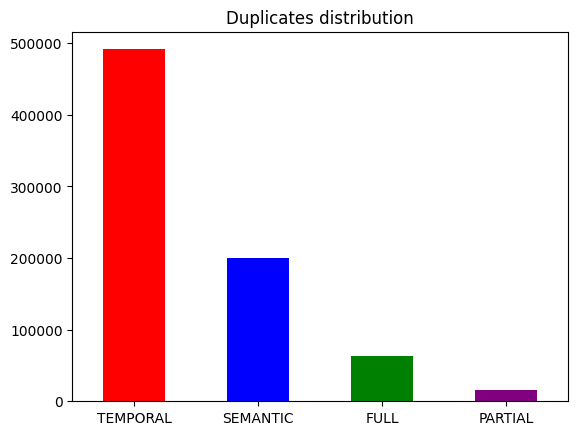

In [21]:
df.TYPE.value_counts().plot(kind='bar', rot=0, color=['red', 'blue', 'green', 'purple'], title='Duplicates distribution')